## Is it a bird?

In [3]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [1]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search
    !pip install -Uqq fastai timm

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
ray 2.0.0 requires click<=8.0.4,>=7.0, but you have click 8.1.3 which is incompatible.
dask-cudf 21.10.1 requires dask==2021.09.1, but you have dask 2022.2.0 which is incompatible.
dask-cudf 21.10.1 requires distributed==2021.09.1, but you have distributed 2022.2.0 which is incompatible.


But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "bird photos"
1. Use DuckDuckGo to search for images of "forest photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

...and then download a URL and take a look at it:

In [14]:

from fastai.vision.all import *


path = untar_data(URLs.CIFAR)/'train'

import cv2

im = cv2.imread('/root/.fastai/data/cifar10/train/horse/49728_horse.png')

print(type(im))
# <class 'numpy.ndarray'>

print(im.shape)
print(type(im.shape))

<class 'numpy.ndarray'>
(32, 32, 3)
<class 'tuple'>


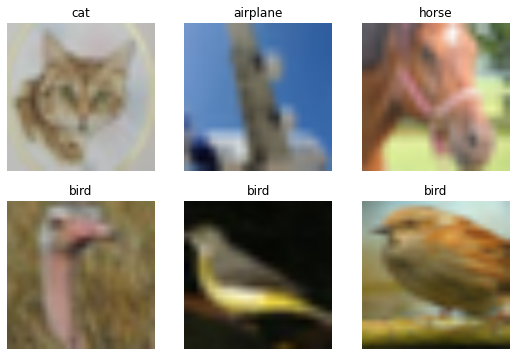

In [17]:
import timm
#timm.list_models(pretrained=True)

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms= RandomResizedCrop(224, min_scale=0.3) #[Resize method='RandomResizeCrop')]
    ).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [18]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.982073,0.555049,0.195300,02:50


epoch,train_loss,valid_loss,error_rate,time
0,0.533721,0.274004,0.093000,02:56
1,0.381342,0.204796,0.069100,02:56


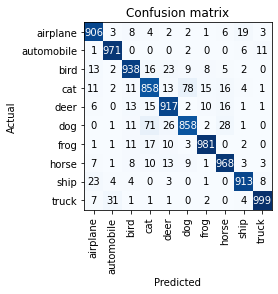

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

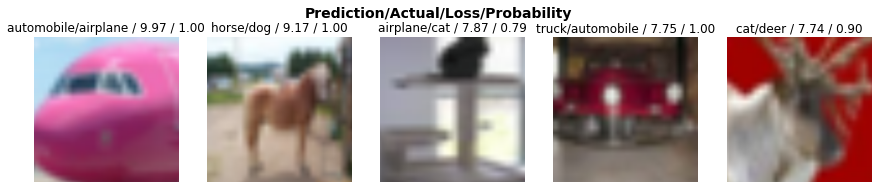

In [20]:
interp.plot_top_losses(5, nrows=1)

In [21]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

In [24]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
#for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/)

In [25]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [26]:
learn_inf = load_learner(path/'export.pkl')

In [27]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [38]:
img = PILImage.create(btn_upload.data[-1])

In [39]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [40]:
pred,pred_idx,probs = learn_inf.predict(img)

In [41]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: cat; Probability: 0.7570')

In [42]:
learn2 = vision_learner(dls, resnet34, metrics=error_rate)
learn2.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.862994,0.466774,0.160200,03:05


epoch,train_loss,valid_loss,error_rate,time
0,0.505487,0.237566,0.082200,03:14
1,0.301148,0.153606,0.051900,03:17


## Step 2: Now for CIFAR_100

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [49]:
path2 = untar_data(URLs.CIFAR_100)/'train'

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

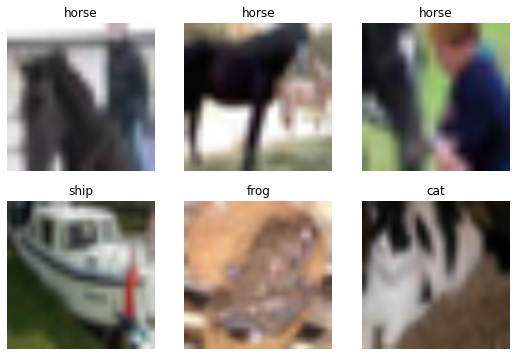

In [50]:
dls2 = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms= RandomResizedCrop(224, min_scale=0.3) #[Resize method='RandomResizeCrop')]
    ).dataloaders(path2, bs=32)

dls.show_batch(max_n=6)

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [52]:
learn3 = vision_learner(dls2, resnet18, metrics=error_rate)
learn3.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,2.686258,1.734624,0.482000,02:51


epoch,train_loss,valid_loss,error_rate,time
0,1.868575,1.161612,0.343100,02:58
1,1.429328,0.939226,0.280000,02:59


In [53]:
learn4 = vision_learner(dls2, resnet34, metrics=error_rate)
learn4.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,2.397060,1.515054,0.431400,03:02


epoch,train_loss,valid_loss,error_rate,time
0,1.709422,1.068763,0.314700,03:11
1,1.241473,0.790184,0.234800,03:13


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Presenting Results

Let's see what our model thinks about that bird we downloaded at the start:

In [69]:
import pandas as pd

results = pd.DataFrame(columns=["CIFAR_error_rate", "CIFAR_time", "CIFAR_100_error_rate","CIFAR_100_time"])
results["CIFAR_error_rate"] = [0.069, 0.052]
results["CIFAR_time"] = [2+(56/60), 3+(17/60)]
results["CIFAR_100_error_rate"] = [0.28, 0.234]
results["CIFAR_100_time"] = [2+(59/60), 3+(13/60)]
results = results.rename(index={0: 'resnet18', 1:'resnet32'})
results

,CIFAR_error_rate,CIFAR_time,CIFAR_100_error_rate,CIFAR_100_time
resnet18,0.069,2.933333,0.280,2.983333
resnet32,0.052,3.283333,0.234,3.216667


Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.